<a href="https://colab.research.google.com/github/trentfridey/qosf-screening/blob/master/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.1.0
!pip install tensorflow-quantum

     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 3.9MB 42.6MB/s 
     |████████████████████████████████| 450kB 44.8MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=bb8970e5c65d2f8fd3fff2aca35ed1b925fe727fee9f5f37456cc8b287afe9d7
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tens

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# Task 1

Initialize the state of 4 qubits $|\psi_0\rangle = |0000\rangle$.

The circuit will consist of a number of layers $L$, each composed of a even and odd block.

The odd block implements the unitary:

$$
U_{2k+1} (\theta_{2k+1}) = R_x(\theta_{2k+1,1})\otimes R_x(\theta_{2k+1,2}) \otimes R_x(\theta_{2k+1,3}) \otimes R_x(\theta_{2k+1,4})
$$

Whereas the even block implements

$$
U_{2k} (\theta_{2k}) = CZ(3,4)CZ(2,4)CZ(2,3)CZ(1,4)CZ(1,3)CZ(1,2)[R_z(\theta_{2k,1})\otimes R_z(\theta_{2k,2}) \otimes R_z(\theta_{2k,3}) \otimes R_z(\theta_{2k,4})]
$$

Let's implement the blocks using Cirq:

In [7]:
# initialize our qubits:

qubits = [cirq.GridQubit(x,y) for x in range(2) for y in range(2)]

# initialize our params (theta)

thetas = sympy.symbols('t1:9')

In [9]:
thetas[0:4]

(t1, t2, t3, t4)

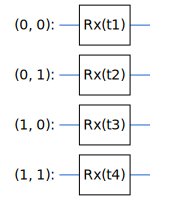

In [10]:
# Lets construct the odd block first
# We will need the Rx gate as well as 4 parameters

odd = cirq.Circuit()
for (qubit, theta) in zip(qubits, thetas[0:4]):
  odd.append(cirq.rx(theta).on(qubit))

SVGCircuit(odd)

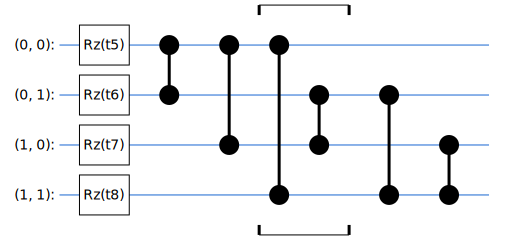

In [13]:
# Now we construct the even block

even = cirq.Circuit()

for (qubit, theta) in zip(qubits, thetas[4:8]):
  even.append(cirq.rz(theta).on(qubit))

for i in range(len(qubits)-1):
  for j in range(i+1, len(qubits)):
    even.append(cirq.CZ(qubits[i], qubits[j]))


SVGCircuit(even)

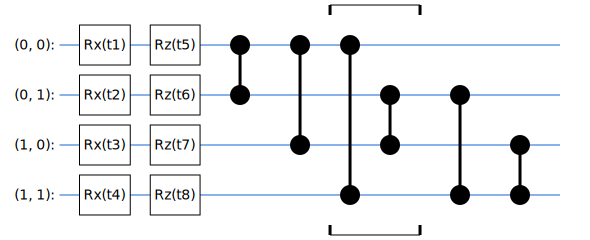

In [15]:
# Now we can combine them into one layer

one_layer = cirq.Circuit()
one_layer.append([odd, even])

SVGCircuit(one_layer)

In [23]:
# Now we can promote the layer to a tensor

one_layer_tensor = tfq.convert_to_tensor([one_layer])
one_layer_tensor

<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'\n\x0e\n\x0ctfq_gate_set\x12\x89\n\x08\x01\x12\xd8\x02\nT\n\x04\n\x02XP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x83\xf9\xa2>\x12\x10\n\x08exponent\x12\x04\x12\x02t1\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\xbf\x1a\x05\x12\x030_0\nT\n\x04\n\x02XP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x83\xf9\xa2>\x12\x10\n\x08exponent\x12\x04\x12\x02t2\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\xbf\x1a\x05\x12\x030_1\nT\n\x04\n\x02XP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x83\xf9\xa2>\x12\x10\n\x08exponent\x12\x04\x12\x02t3\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\xbf\x1a\x05\x12\x031_0\nT\n\x04\n\x02XP\x12\x10\n\x08exponent\x12\x04\x12\x02t4\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\xbf\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x83\xf9\xa2>\x1a\x05\x12\x031_1\x12\xd8\x02\nT\n\x04\n\x02ZP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x83\xf9\xa2>\x12\x10\n\x08exponent\x12\x04\x12\x0

In [22]:
# Or try to convert it to a Keras layer

add = tfq.layers.AddCircuit()
output = add(one_layer, append=one_layer)
output

<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'\n\x0e\n\x0ctfq_gate_set\x12\x90\x14\x08\x01\x12\xd8\x02\nT\n\x04\n\x02XP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x83\xf9\xa2>\x12\x10\n\x08exponent\x12\x04\x12\x02t1\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\xbf\x1a\x05\x12\x030_0\nT\n\x04\n\x02XP\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\xbf\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x83\xf9\xa2>\x12\x10\n\x08exponent\x12\x04\x12\x02t2\x1a\x05\x12\x030_1\nT\n\x04\n\x02XP\x12\x10\n\x08exponent\x12\x04\x12\x02t3\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\xbf\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x83\xf9\xa2>\x1a\x05\x12\x031_0\nT\n\x04\n\x02XP\x12\x10\n\x08exponent\x12\x04\x12\x02t4\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\xbf\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x83\xf9\xa2>\x1a\x05\x12\x031_1\x12\xd8\x02\nT\n\x04\n\x02ZP\x12\x10\n\x08exponent\x12\x04\x12\x02t5\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x0

The figure of interest at this stage is the final state, $|\psi(\vec{\theta})\rangle$, and the quantity:

$$
\delta = || |\psi(\vec{\theta})\rangle - |\phi\rangle ||
= \sum_{i,j,k,l}|c_{ijkl}|^2
$$

$$
c_{ijkl} = \langle ijkl|\psi(\vec{\theta})\rangle - \langle ijkl|\phi\rangle
$$

Where $|\phi\rangle$ is a randomly chosen state

In [ ]:
# Let's try adding a State layer to our model

In [ ]:
# Calculate the final state
# For the current example, we need to pick values for our parameters

params = {t1: 0, t2: 0.5, t3: 0.5, t4: 0.3, t5: 0.2, t6: 0.7, t7: 0.1, t8: 0}

resolver = cirq.ParamResolver(params)
final_state = cirq.Simulator().simulate(one_layer, resolver).final_state
final_state


array([ 0.8146157 -0.4450266j , -0.06725919-0.12311712j,
       -0.09230035-0.21831085j,  0.03299445-0.01394983j,
        0.0470888 -0.2322964j ,  0.03510817+0.00711678j,
        0.05781832+0.0178853j ,  0.0027031 -0.00873838j,
        0.        +0.j        , -0.        +0.j        ,
       -0.        +0.j        ,  0.        +0.j        ,
       -0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ], dtype=complex64)

In [ ]:
# Calculate the delta quantity
# We need a randomly generated 4 qubit state

phi = cirq.testing.random_superposition(2**4)

delta = np.linalg.norm(final_state - phi)

delta

1.3362383456818439

Now that we can calculate the $\delta$ quantity, we want to be able to minimize it over the parameters $\vec{\theta}$, to obtain a further quantity $\epsilon = \min_{\vec{\theta}} \delta$